Strong effort at a particle filtering rollout, where we use a trained model and try to predict an autoregressive rollout in order to do a good job.

I then apply a particle filtering approach to select only my favourite samples to see if I can produce a good rollout.

Really make sure this works.

In [1]:
# hack to go a couple of directories up if we need to import from python files in some parent directory.

import os
import sys

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import json

import torch
import torch.fft as fft
import matplotlib.pyplot as plt

import xarray as xr

import seaborn as sns
from mpl_toolkits.basemap import Basemap
import cv2

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import glob

import random

from tqdm.auto import tqdm
import matplotlib.cm as cm

import scipy.stats as stats
from scipy.interpolate import griddata

import climatem.climate_dataset_test_ensembles as climate_dataset
from climatem.climate_data_loader_test_ensembles import CausalClimateDataModule
from climatem.metrics import edge_errors, mcc_latent, precision_recall, shd, w_mae
from climatem.model.tsdcd_latent_explore import LatentTSDCD
#from climatem.train_latent_constrain_graph_multigpu_pf import TrainingLatent

# import all the necessary mean squared error functions and so on
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

/home/mila/s/sebastian.hickman/.conda/envs/env_emulator_conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/mila/s/sebastian.hickman/.conda/envs/env_emulator_conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [3]:
# Plotting functions for videos of the rollouts.

def plot_preds_icosa_robin(data, coordinates, axs, timestep, out_dir, show_plot=True):

    axs.set_global()
    axs.coastlines()
    # Add some map features for context
    axs.add_feature(cfeature.BORDERS, linestyle=':')
    axs.add_feature(cfeature.COASTLINE)
    axs.add_feature(cfeature.LAND, edgecolor='black')
    axs.gridlines(draw_labels=False)

    # Unpack coordinates for vectorized scatter plot
    x = coordinates[:, 0]
    y = coordinates[:, 1]

    # Vectorized scatter plot with color array
    s = axs.scatter(x=x, y=y, c=data, alpha=1, s=30, vmin=-3.5, vmax=3.5, cmap="RdBu_r", transform=ccrs.PlateCarree())  # Store scatter plot object

    # add a colorbar
    plt.colorbar(s, ax=axs, label="Normalised anomaly", orientation="vertical", shrink=1.0) # adjust shrink
    #axs.colorbar(s, ax=axs, label="Normalised slp", orientation="vertical", shrink=1.0) # adjust shrink

    # add a title
    plt.title(f"Timestep {timestep} of model autoregressive rollout (months)")
    
    fname = f"{out_dir}/just_icosa_pred_timestep_{timestep}.png"
    #plt.suptitle(f"Plot of timestep {timestep}")    
    plt.savefig(fname)

    if show_plot == False:
        plt.close()

    #plt.close()

def plot_preds_icosa_robin_video_array(each_timestep, coordinates:np.ndarray, out_dir:str, fname:str, show_plot:bool = True):
    '''
    Plotting global maps of the predictions using the Robinson projection.
    We use the plot_preds_icosa_robin function.
    '''
    img_array = []
    for timestep in range(len(each_timestep)):
        fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()}, figsize=(12, 6))
        plot_preds_icosa_robin(each_timestep[timestep, 88, 0, :], coordinates, ax, timestep, "plots", show_plot=show_plot)
        filename = f"{out_dir}/just_icosa_pred_timestep_{timestep}.png"
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width, height)
        img_array.append(img)
        # add a title to the plot
        ax.set_title(f'Autoregressive rollout, timestep {timestep}')
        # add a colorbar
        
    print('Done plotting all samples.')

    out = cv2.VideoWriter(f'{out_dir}/{fname}.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 3, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()


In [4]:
# Read the coordinates too...

coordinates = np.loadtxt("/home/mila/s/sebastian.hickman/work/icosahedral/mappings/vertex_lonlat_mapping.txt")
coordinates = coordinates[:, 1:]

# Load up and try to use a saved model

In [7]:
# path to the results directory that I care about

#results_dir = "/home/mila/s/sebastian.hickman/scratch/results/climatem_spectral/var_['ts', 'tas', 'psl']_scenarios_piControl_tau_5_z_90_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_2_instantaneous_False_crpscoef_0_spcoef_0_tempspcoef_5000_2/"
#results_dir_hivar = "/home/mila/s/sebastian.hickman/scratch/results/climatem_spectral/var_['ts', 'tas', 'psl']_scenarios_piControl_tau_5_z_90_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_2_instantaneous_False_crpscoef_0_spcoef_0_tempspcoef_5000/"
#results_dir_novae = "/home/mila/s/sebastian.hickman/scratch/results/climatem_spectral/var_['ts', 'tas', 'psl']_scenarios_piControl_tau_5_z_90_lr_0.001_spreg_0.40743_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_2_spcoef_1_tempspcoef_1000/"

# Now doing for two models, one where we learned a causal graph (taking the final model) and one where we didn't

results_dir_ts_vae = "/home/mila/s/sebastian.hickman/scratch/results/climatem_spectral/var_['ts']_scenarios_piControl_tau_5_z_90_lr_0.001_spreg_0.743706_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_2_instantaneous_False_crpscoef_1_spcoef_20_tempspcoef_2000/"
results_dir_ts_novae = "/home/mila/s/sebastian.hickman/scratch/results/climatem_spectral/var_['ts']_scenarios_piControl_tau_5_z_90_lr_0.001_spreg_0.743706_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_2_instantaneous_False_crpscoef_1_spcoef_20_tempspcoef_2000/"


In [8]:
# make sure we use the correct directory here

with open(results_dir_ts_vae + "params.json", 'r') as f:
    hp = json.load(f)

In [9]:
# Let's overwrite some of the hyperparameters to see if we can load in some different ssp data...
hp

# overwrite the config_exp_path here:

hp['config_exp_path'] = '/home/mila/s/sebastian.hickman/work/climatem/scripts/configs/climate_predictions_picontrol_icosa_nonlinear_ensembles_hilatent_all_icosa_picontrol.json'
#hp['config_exp_path'] = '/home/mila/s/sebastian.hickman/work/climatem/scripts/configs/climate_predictions_picontrol_icosa_nonlinear_ensembles_hilatent_all_icosa_ssp126.json'
#hp['config_exp_path'] = '/home/mila/s/sebastian.hickman/work/climatem/scripts/configs/climate_predictions_picontrol_icosa_nonlinear_ensembles_hilatent_all_icosa_ssp245.json'


In [10]:
# once I have loaded in the state_dict, I can load it into a model
# first I need to define the model architecture

config_fname = hp['config_exp_path']
with open(config_fname) as f:
    data_params = json.load(f)

datamodule = CausalClimateDataModule(**data_params) #...
datamodule.setup()

# getting the training data in place so that I can forecast using this data.
train_dataloader = iter(datamodule.train_dataloader())
# val_dataloader = iter(datamodule.val_dataloader())
x, y = next(train_dataloader)
x = torch.nan_to_num(x)
y = torch.nan_to_num(y)
y = y[:, 0]
z = None

# some little numbers that I am going to need later:
d = x.shape[2]
num_input = d * hp['tau'] * (hp['tau_neigh'] * 2 + 1)

Test models: None
TEST SET NAMES ['ssp370_NorESM2-LM', 'ssp126_NorESM2-LM']
1600-2100
1894-2000
['piControl']
IN CMIP6!!!
KWARGs: {'climate_model': 'NorESM2-LM', 'num_ensembles': 1, 'years': '1600-2100', 'historical_years': '1894-2000', 'variables': ['ts'], 'scenarios': ['piControl'], 'channels_last': False, 'seq_to_seq': True}
climate_model_NorESM2-LM_num_ensembles_1_years_1600-2100_historical_years_1894-2000_variables_ts_scenarios_piControl_channels_last_False_seq_to_seq_True_train+val_target.npz
path exists, reloading
KWARGs: {'climate_model': 'NorESM2-LM', 'num_ensembles': 1, 'years': '1600-2100', 'historical_years': '1894-2000', 'variables': ['ts'], 'scenarios': ['piControl'], 'channels_last': False, 'seq_to_seq': True}
NorESM2-LM_1_ts_train+val_statistics.npy
Normalizing data...
I completed the normalisation of the data.
Really, I completed the normalisation of the data, just about to return.
Removing seasonality from the data.


Just about to return the data after removing seasonality.
In CMIP6Dataset, just finished removing the seasonality.
CMIP6 shape (501, 12, 1, 6250)
Getting causal data [mode=train+val] ...
In get_causal_data, num_years: 501
Here in get_causal_data, self.length: 501
Trying to regrid to lon, lat if we have regular data...
I saw a ValueError and now I am reshaping the data differently, probably as I have icosahedral data!
Data shape before reshaping: (501, 12, 1, 6250)
JUST CHECKING I AM HERE
Data shape after reshaping: (1, 6012, 1, 6250)
1100-1150
IN CMIP6!!!
KWARGs: {'climate_model': 'NorESM2-LM', 'num_ensembles': 1, 'years': '1600-2100', 'historical_years': '1894-2000', 'variables': ['ts'], 'scenarios': ['piControl'], 'channels_last': False, 'seq_to_seq': True}
climate_model_NorESM2-LM_num_ensembles_1_years_1600-2100_historical_years_1894-2000_variables_ts_scenarios_piControl_channels_last_False_seq_to_seq_True_train+val_target.npz
path exists, reloading
KWARGs: {'climate_model': 'NorESM

In [12]:
# Instantiate a model here with the hyperparameters that we have loaded in.
model = LatentTSDCD(num_layers=hp['num_layers'],
                            num_hidden=hp['num_hidden'],
                            num_input=num_input,
                            num_output=2,
                            num_layers_mixing=hp['num_layers_mixing'],
                            num_hidden_mixing=hp['num_hidden_mixing'],
                            coeff_kl=hp['coeff_kl'],
                            d=d,
                            distr_z0="gaussian",
                            distr_encoder="gaussian",
                            distr_transition="gaussian",
                            distr_decoder="gaussian",
                            d_x=hp['d_x'],
                            d_z=hp['d_z'],
                            tau=hp['tau'],
                            instantaneous=hp['instantaneous'],
                            nonlinear_mixing=hp['nonlinear_mixing'],
                            hard_gumbel=hp['hard_gumbel'],
                            no_gt=hp['no_gt'],
                            debug_gt_graph=hp['debug_gt_graph'],
                            debug_gt_z=hp['debug_gt_z'],
                            debug_gt_w=hp['debug_gt_w'],
                            # gt_w=data_loader['gt_w'],
                            # gt_graph=data_loader['gt_graph'],
                            tied_w=hp['tied_w'],
                            # NOTE: seb adding fixed to try to test when we have a fixed graph
                            # also 
                            fixed=hp['fixed'],
                            fixed_output_fraction=hp['fixed_output_fraction'])

We are setting the Mask here.


Load saved model weights.

In [15]:
# Here we have the final model, when we do learn the causal graph.

state_dict_vae_final = torch.load(results_dir_ts_vae + "model.pth", map_location='cpu')
model.load_state_dict({k.replace("module.", ""): v for k, v in state_dict_vae_final.items()})

<All keys matched successfully>

In [14]:
# Here we do not learn the causal graph, and we do early stopping on the validation set for the spectra.

state_dict_novae = torch.load(results_dir_ts_novae + "best_model_for_average_spectra.pth", map_location='cpu')
model.load_state_dict({k.replace("module.", ""): v for k, v in state_dict_novae.items()})

<All keys matched successfully>

In [16]:
scratch_path = "/home/mila/s/sebastian.hickman/scratch/results/dec30_particle_filters/ts_picontrol/"
#scratch_path = "/home/mila/s/sebastian.hickman/scratch/results/dec30_particle_filters/ts_ssp126/"
#scratch_path = "/home/mila/s/sebastian.hickman/scratch/results/dec30_particle_filters/ts_ssp245/"


Do a bare rollout first, then do a rollout where we select only the best particle.

In [36]:
# Let's check that we can do a small autoregressive rollout:

with torch.no_grad():
    y_pred, y_spare, z, pz_mu, pz_std = model.predict(x, y)

# check that y_spare and y are the same
assert torch.allclose(y_spare, y)

# make a copy of y_pred, which is a tensor
x_original = x.clone().detach()
y_original = y.clone().detach()
y_original_pred = y_pred.clone().detach()

print(x_original[:, -1, :, :].shape)
print(y_original_pred.shape)

# save these original values, x_original, y_orginal, y_original_pred
# select only the last element of x_orginal
np.save(os.path.join(scratch_path, "finalvae_train_x_ar_0.npy"), x_original[:, -1, :, :].detach().cpu().numpy())
#np.save(os.path.join(scratch_path, "vae_train_y_ar_0.npy"), y_original.detach().cpu().numpy())
np.save(os.path.join(scratch_path, "finalvae_train_y_pred_ar_0.npy"), y_original_pred.detach().cpu().numpy())

# Now doing the autoregressive rollout...
# TODO: implement the autoregressive rollout and also take samples

print('About to do the autoregressive rollout')
for i in range(1, 60):

    print(f"Doing autoregressive rollout for timestep {i}")
    # assert that x_original and x are the same
    if i == 1:
        assert torch.allclose(x_original, x)

    # remove the first timestep, so now we have (tau - 1) timesteps,
    # then append the prediction
    x = x[:, 1:, :, :]
    x = torch.cat([x, y_pred.unsqueeze(1)], dim=1)


    # then predict the next timestep
    # y at this point is pointless!!!
    
    with torch.no_grad():
        y_pred, y, z, pz_mu, pz_std = model.predict(x, y)

    assert i != 0
    np.save(os.path.join(scratch_path, f"finalvae_train_x_ar_{i}.npy"), x[:, -1, :, :].detach().cpu().numpy())
    #np.save(os.path.join(scratch_path, f"vae_train_y_ar_{i}.npy"), y.detach().cpu().numpy())
    np.save(os.path.join(scratch_path, f"finalvae_train_y_pred_ar_{i}.npy"), y_pred.detach().cpu().numpy())

torch.Size([256, 1, 6250])
torch.Size([256, 1, 6250])
About to do the autoregressive rollout
Doing autoregressive rollout for timestep 1
Doing autoregressive rollout for timestep 2
Doing autoregressive rollout for timestep 3
Doing autoregressive rollout for timestep 4
Doing autoregressive rollout for timestep 5
Doing autoregressive rollout for timestep 6
Doing autoregressive rollout for timestep 7
Doing autoregressive rollout for timestep 8
Doing autoregressive rollout for timestep 9
Doing autoregressive rollout for timestep 10
Doing autoregressive rollout for timestep 11
Doing autoregressive rollout for timestep 12
Doing autoregressive rollout for timestep 13
Doing autoregressive rollout for timestep 14
Doing autoregressive rollout for timestep 15
Doing autoregressive rollout for timestep 16
Doing autoregressive rollout for timestep 17
Doing autoregressive rollout for timestep 18
Doing autoregressive rollout for timestep 19
Doing autoregressive rollout for timestep 20
Doing autoregres

# Here we do the same rollout but with rejection sampling/particle filtering.

In [17]:
# Now I want to apply my particle filter to this puppy.

def score_the_samples_for_spatial_spectra(y_true, y_pred_samples, num_samples=100):
    '''
    Calculate the spatial spectra of the true values and the predicted values, 
    and then calculate a score between them. This is a measure of how well the model is 
    predicting the spatial spectra of the true values.

    Args:
        true_values: torch.Tensor, observed values in a batch
        y_pred: torch.Tensor, a selection of predicted values
        num_samples: int, the number of samples that have been taken from the model
    '''
    
    # calculate the average spatial spectra of the true values, averaging across the batch
    print("y_true shape:", y_true.shape)
    fft_true = torch.mean(torch.abs(torch.fft.rfft(y_true[:, :, :], dim=2)), dim=0)
    # calculate the average spatial spectra of the individual predicted fields - I think this below is wrong
    print("y_pred shape:", y_pred_samples.shape)
    fft_pred = torch.mean(torch.abs(torch.fft.rfft(y_pred_samples[:, :, :], dim=3)), dim=1)

    # extend fft_true so it is the same value but extended to the same shape as fft_pred
    fft_true = fft_true.repeat(num_samples, 1, 1)

    # assert that the first two elements of fft_true are the same
    assert torch.allclose(fft_true[0, :, :], fft_true[1, :, :])

    print("fft_true shape after repeating:", fft_true.shape)
    print("fft_pred shape:", fft_pred.shape)

    # calculate the difference between the true and predicted spatial spectra
    spatial_spectra_score = torch.abs(fft_pred - fft_true)
    print("Spatial spectra score raw from the fft:", spatial_spectra_score)
    # take the mean of the spatial spectra score across the variables and the wavenumbers, the final 2 axes
    spatial_spectra_score = torch.mean(spatial_spectra_score, dim=(1, 2))
    print("Spatial spectra score meaned shape:", spatial_spectra_score.shape)

    # then normalise all the values of spatial_spectra_score by the maximum value
    # this is to make sure that the score is between 0 and 1
    spatial_spectra_score = spatial_spectra_score / torch.max(spatial_spectra_score)
    print("Spatial spectra score normalised:", spatial_spectra_score)

    # the do 1 - score to give the score to be increasing...
    spatial_spectra_score = 1 - spatial_spectra_score
    print("Spatial spectra score doing 1 - score:", spatial_spectra_score)

    # score = ...  
    return spatial_spectra_score

def score_the_samples_for_variance(y_true, y_pred_samples, num_samples=100):

    print("y_true shape:", y_true.shape)
    print("y_pred_samples shape:", y_pred_samples.shape)
    
    # calculate the variance of the true values
    var_true = torch.var(y_true, dim=(2))

    # calculate the variance of the predicted values
    var_pred = torch.var(y_pred_samples, dim=(3))

    print("var true shape:", var_true.shape)
    print("var pred shape:", var_pred.shape)

    # extend var_true so it is the same value but extended to the same shape as var_pred
    var_true = var_true.repeat(num_samples, 1, 1)

    print("var true shape", var_true.shape)

    # calculate the difference between the true and predicted variances
    variance_score = torch.abs(var_true - var_pred)
    #print("Variance score raw:", variance_score)
    print("variance score shape:", variance_score.shape)
    # take the mean of the variance score across the variables and the wavenumbers, the final 2 axes
    variance_score = torch.mean(variance_score, dim=(2))

    print("minimum variance score:", torch.min(variance_score))
    print("maximum variance score:", torch.max(variance_score))
    
    #print("Variance score meaned shape:", variance_score.shape)
    # normalise the variance score
    #variance_score = variance_score / torch.max(variance_score)

    # then do 1 - score
    #variance_score = 1 - variance_score
    #print("variance score return after normalising and 1 -:", variance_score)

    print("The variance score shape should be the same as the number of samples:", variance_score.shape)
    print("Variance score shape:", variance_score.shape)

    print("What element of y_pred_samples has the highest variance - which is max variance?", torch.max(torch.var(y_pred_samples, dim=(2, 3))))

    return variance_score

def particle_filter(x, y, num_particles, timesteps=120):
    '''
    Implement a particle filter to make a set of autoregressive predictions, where each created sample is 
    evaluated by some score, and we do a particle filter to select only best samples to continue the autoregressive rollout.
    '''

    print('Number of particles:', num_particles)
    #particles = torch.randn(num_particles)
    #weights = torch.ones(num_particles) / num_particles

    print('Initial number of particles:', num_particles)

    for _ in range(timesteps):
        print(f"Doing timestep {_}")
        # Prediction
        # make all the new predictions, taking samples from the latents
        unused_samples_from_xs, samples_from_zs, y = model.predict_sample(x, y, num_particles)

        # then calculate the score of each of the samples
        # Update the weights, where we want the weights to increase as the score improves
        
        new_weights = score_the_samples_for_variance(y, samples_from_zs, num_particles)
        # Resampling (e.g., systematic resampling)
        #indices = torch.multinomial(new_weights, num_particles, replacement=True)
        #selected_samples = samples_from_zs[indices]
        #weights = torch.ones(num_particles) / num_particles

        # print the index of the smallest value in new_weights

        print('Minimum of the new weights:', torch.min(new_weights))
        print('Maximum of the new weights:', torch.max(new_weights))

        print("Shape of the new weights", new_weights.shape)
        # (new_samples, batch_size)

        print('Indices of the minimum of the new weights:', torch.argmin(new_weights, dim=0))
        
        # for each of the batch_size dim, choose the element of samples_from_z with the index torch.argmin(new_weights, dim=0)

        indices = torch.argmin(new_weights, dim=0)        
        
        # create a random array with the same shape as indices, with integer values between 0 and 4
        indices_rnd = torch.randint(0, 4, (256,))


        print("Samples from z shape", samples_from_zs.shape)
        
        # calculate the range in variances between the 20 samples for each element of the batch
        print('The range in variance of the samples from z, per batch member:', torch.max(torch.var(samples_from_zs, dim=(2, 3))) - torch.min(torch.var(samples_from_zs, dim=(2, 3))))

        #print("What is the variance of the samples from z:", torch.var(samples_from_zs, dim=(1, 2, 3)))



        # this may produce some problems from using numpy?

        # for each of the second dimension of samples_from_z, choose the element of samples_from_z with the index torch.argmin(new_weights, dim=0)
        #THIS MIGHT WORK: selected_samples = torch.stack([samples_from_zs[indices[i], i, :, :] for i in range(samples_from_zs.shape[1])], dim=1)        
        selected_samples = samples_from_zs[indices, np.arange(256), :, :]
        selected_samples_random = samples_from_zs[indices_rnd, np.arange(256), :, :]

        #weights = torch.ones(num_particles) / num_particles

        #print("What is the shape of the selected samples", selected_samples.shape)

        #print("What is the variance of the selected samples:", torch.var(selected_samples, dim=(1, 2)))
        #print("What is the variance of the selected samples random:", torch.var(selected_samples_random, dim=(1, 2)))

        # assert that for each element of the two torch.var, for the selected_samples_random it is greater than or equal to the selected_samples
        #print(torch.all(torch.var(selected_samples_random, dim=(1, 2)) >= torch.var(selected_samples, dim=(1, 2))))
        print(torch.var(selected_samples_random, dim=(1, 2)) >= torch.var(selected_samples, dim=(1, 2)))
        # check that selected_samples is the same as the one with the smallest value in new_weights
        # unsqueeze the selected samples

        # insert code here...
        # store these selected_samples
        np.save(os.path.join("/home/mila/s/sebastian.hickman/scratch/results/dec30_particle_filters/ts_picontrol/", f"pfvar_500_samples_finalvae_best_sample_train_y_pred_ar_{_}.npy"), selected_samples.detach().cpu().numpy())

        # then we are going to be passing the selected samples to the next timestep, so we need to make the input again
        # first drop the first value of x, then
        x = x[:, 1:, :, :]

        # now we just need to unsqueeze the selected samples, so that we can concatenate them to x
        selected_samples = selected_samples.unsqueeze(1)

        print("What is the shape of x, just before we concatenate?", x.shape)
        print("What is the shape of the selected samples, just before we concatenate?", selected_samples.shape)

        # then we need to append the selected samples to x, along the right axis
        x = torch.cat([x, selected_samples], dim=1)

        # then we are going back to the top of the loop     

    return selected_samples

Deploy this in a standard rollout.

Remember that we need to reload the x, y data!!

In [51]:
final_picontrol_particles = particle_filter(x, y, num_particles=500, timesteps=60)


Number of particles: 500
Initial number of particles: 500
Doing timestep 0


y_true shape: torch.Size([256, 1, 6250])
y_pred_samples shape: torch.Size([500, 256, 1, 6250])
var true shape: torch.Size([256, 1])
var pred shape: torch.Size([500, 256, 1])
var true shape torch.Size([500, 256, 1])
variance score shape: torch.Size([500, 256, 1])
minimum variance score: tensor(4.7684e-06)
maximum variance score: tensor(0.7938)
The variance score shape should be the same as the number of samples: torch.Size([500, 256])
Variance score shape: torch.Size([500, 256])
What element of y_pred_samples has the highest variance - which is max variance? tensor(1.7063)
Minimum of the new weights: tensor(4.7684e-06)
Maximum of the new weights: tensor(0.7938)
Shape of the new weights torch.Size([500, 256])
Indices of the minimum of the new weights: tensor([282, 174, 223, 192,  17, 465, 262, 316, 138, 199, 173, 455, 272,  91,
         77, 155, 278, 376, 177,  99, 402, 476, 420, 409, 320, 269, 382, 279,
        193, 490, 418, 281, 249, 332, 230, 125, 256, 124, 312, 303,  17,  83,
      

# Inspect and plot the standard and filtered rollouts of the model...

In [18]:
picontrol_scratch_path = "/home/mila/s/sebastian.hickman/scratch/results/dec30_particle_filters/ts_picontrol/"

In [19]:
def load_timesteps_to_array(scratch_path, filename_stem, timesteps):

    each_timestep = []

    for i in range(0, timesteps):
        x = np.load(scratch_path + filename_stem + f'_x_ar_{i}.npy')
        #y = np.load(f'train_y_ar_{i}.npy')
        y_preds = np.load(scratch_path + filename_stem + f'_y_pred_ar_{i}.npy')

        each_timestep.append((x, y_preds))

    # Now make an array using each_timestep
    each_timestep_array = np.array(each_timestep)

    return each_timestep_array

In [20]:
each_timestep_finalvae_picontrol_array = load_timesteps_to_array(picontrol_scratch_path, 'finalvae_train', 60)

# This doesn't work at the moment because I did not save xs.
#each_timestep_pfvar_20_samples_finalvae_picontrol_array = load_timesteps_to_array(picontrol_scratch_path, 'pfvar_finalvae_best_sample_train', 60)

Do this manually for now.

In [48]:
each_timestep = []

for i in range(0, 48):
    x = np.load(picontrol_scratch_path + f'finalvae_train_x_ar_{i}.npy')
    #y = np.load(f'train_y_ar_{i}.npy')
    y_preds = np.load(picontrol_scratch_path + f'pfvar_finalvae_best_sample_train_y_pred_{i}.npy')

    each_timestep.append((x, y_preds))

# Now make an array using each_timestep
each_timestep_pfvar_20_samples_finalvae_picontrol_array = np.array(each_timestep)

each_timestep = []

for i in range(0, 60):
    x = np.load(picontrol_scratch_path + f'finalvae_train_x_ar_{i}.npy')
    #y = np.load(f'train_y_ar_{i}.npy')
    y_preds = np.load(picontrol_scratch_path + f'pfvar_100_samples_finalvae_best_sample_train_y_pred_ar_{i}.npy')

    each_timestep.append((x, y_preds))

# Now make an array using each_timestep
each_timestep_pfvar_100_samples_finalvae_picontrol_array = np.array(each_timestep)

each_timestep = []

for i in range(0, 60):
    x = np.load(picontrol_scratch_path + f'finalvae_train_x_ar_{i}.npy')
    #y = np.load(f'train_y_ar_{i}.npy')
    y_preds = np.load(picontrol_scratch_path + f'pfvar_500_samples_finalvae_best_sample_train_y_pred_ar_{i}.npy')

    each_timestep.append((x, y_preds))

# Now make an array using each_timestep
each_timestep_pfvar_500_samples_finalvae_picontrol_array = np.array(each_timestep)

## Check the variance of the data here.

In [49]:
each_timestep_finalvae_picontrol_array[0:48].shape

(48, 2, 256, 1, 6250)

In [50]:
print(np.var(each_timestep_finalvae_picontrol_array[0:48, 1, :, 0, :], axis=(2)).shape)
print(np.var(each_timestep_pfvar_20_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)).shape)
print(np.var(each_timestep_pfvar_100_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)).shape)


print(np.mean(np.var(each_timestep_finalvae_picontrol_array[0:48, 1, :, 0, :], axis=(2)), axis=1))
print(np.mean(np.var(each_timestep_pfvar_20_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), axis=1))
print(np.mean(np.var(each_timestep_pfvar_100_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), axis=1))

print(np.median(np.var(each_timestep_finalvae_picontrol_array[0:48, 1, :, 0, :], axis=(2)), axis=1))
print(np.median(np.var(each_timestep_pfvar_20_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), axis=1))
print(np.median(np.var(each_timestep_pfvar_100_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), axis=1))

(48, 256)
(48, 256)
(60, 256)
[6.1912537e-01 6.1950153e-01 6.3578635e-01 6.5797317e-01 6.8450338e-01
 7.2847241e-01 7.5408947e-01 7.9564142e-01 8.4384066e-01 9.0470207e-01
 9.7603941e-01 1.0663145e+00 1.1779472e+00 1.3346763e+00 1.5343865e+00
 1.7080709e+00 1.9563149e+00 2.2622619e+00 2.6182628e+00 3.1612802e+00
 3.8898411e+00 4.8422818e+00 6.1909313e+00 7.9317179e+00 1.1217342e+01
 1.5480700e+01 2.1681538e+01 3.3322868e+01 5.0476391e+01 7.9051125e+01
 1.3914410e+02 2.2069360e+02 3.6037885e+02 5.8266486e+02 9.4135425e+02
 1.4774403e+03 2.3018052e+03 3.5157803e+03 5.4551973e+03 8.1522300e+03
 1.2848493e+04 2.0040006e+04 3.3049418e+04 5.4748348e+04 9.5091430e+04
 1.5771645e+05 2.7745781e+05 4.5346194e+05]
[8.1864464e-01 8.8416457e-01 9.1260606e-01 9.4989538e-01 9.5739532e-01
 9.8610139e-01 9.9720007e-01 1.0266625e+00 1.0467153e+00 1.0740211e+00
 1.0897832e+00 1.0922701e+00 1.1531932e+00 1.1785178e+00 1.1962850e+00
 1.2731285e+00 1.3352560e+00 1.3872786e+00 1.4767463e+00 1.5667582e+00
 1.

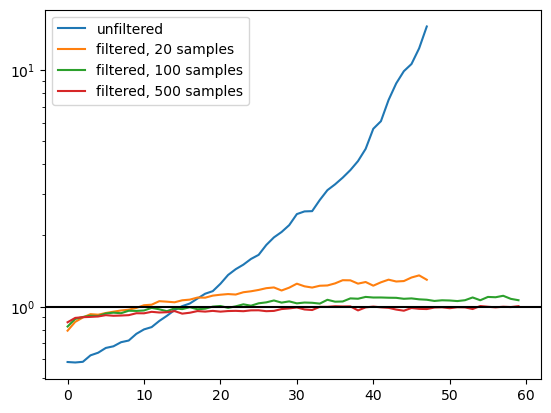

In [51]:
plt.plot(np.median(np.var(each_timestep_finalvae_picontrol_array[0:48, 1, :, 0, :], axis=(2)), axis=1), label='unfiltered')
plt.plot(np.median(np.var(each_timestep_pfvar_20_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), axis=1), label='filtered, 20 samples')
plt.plot(np.median(np.var(each_timestep_pfvar_100_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), axis=1), label='filtered, 100 samples')
plt.plot(np.median(np.var(each_timestep_pfvar_500_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), axis=1), label='filtered, 500 samples')

plt.axhline(1, color='k')

plt.legend()

# make the y axis a log scale

plt.yscale('log')


## Load up the CMIP data here too.

In [52]:
# create a list of strings containing the years 1600 to 2100 
picontrol_years = [str(year) for year in range(1600, 2101)] 

cmip_dataset_ts = climate_dataset.CMIP6Dataset(years=picontrol_years, 
                                            historical_years="1850-2100", 
                                            data_dir="/home/mila/s/sebastian.hickman/scratch/data/icosahedral_data/structured/picontrol/24_ni",
                                            variables=["ts"],
                                            climate_model='NorESM2-LM',
                                            scenarios=['piControl'],
                                            mode='train+val',
                                            channels_last=False,
                                            seasonality_removal=True)

IN CMIP6!!!
KWARGs: {'climate_model': 'NorESM2-LM', 'num_ensembles': 1, 'years': '1600-2100', 'historical_years': '1-0', 'variables': ['ts'], 'scenarios': ['piControl'], 'channels_last': False, 'seq_to_seq': True}
climate_model_NorESM2-LM_num_ensembles_1_years_1600-2100_historical_years_1-0_variables_ts_scenarios_piControl_channels_last_False_seq_to_seq_True_train+val_target.npz
path exists, reloading
KWARGs: {'climate_model': 'NorESM2-LM', 'num_ensembles': 1, 'years': '1600-2100', 'historical_years': '1-0', 'variables': ['ts'], 'scenarios': ['piControl'], 'channels_last': False, 'seq_to_seq': True}
NorESM2-LM_1_ts_train+val_statistics.npy
Normalizing data...
I completed the normalisation of the data.
Really, I completed the normalisation of the data, just about to return.
Removing seasonality from the data.
Just about to return the data after removing seasonality.
In CMIP6Dataset, just finished removing the seasonality.
CMIP6 shape (501, 12, 1, 6250)


In [53]:
cmip_dataset_ts
cmip_dataset_ts_monthed = cmip_dataset_ts.Data.reshape(-1, 1, 6250)


Text(0.5, 1.0, 'Samples of 500 filtered rollout, causal graph')

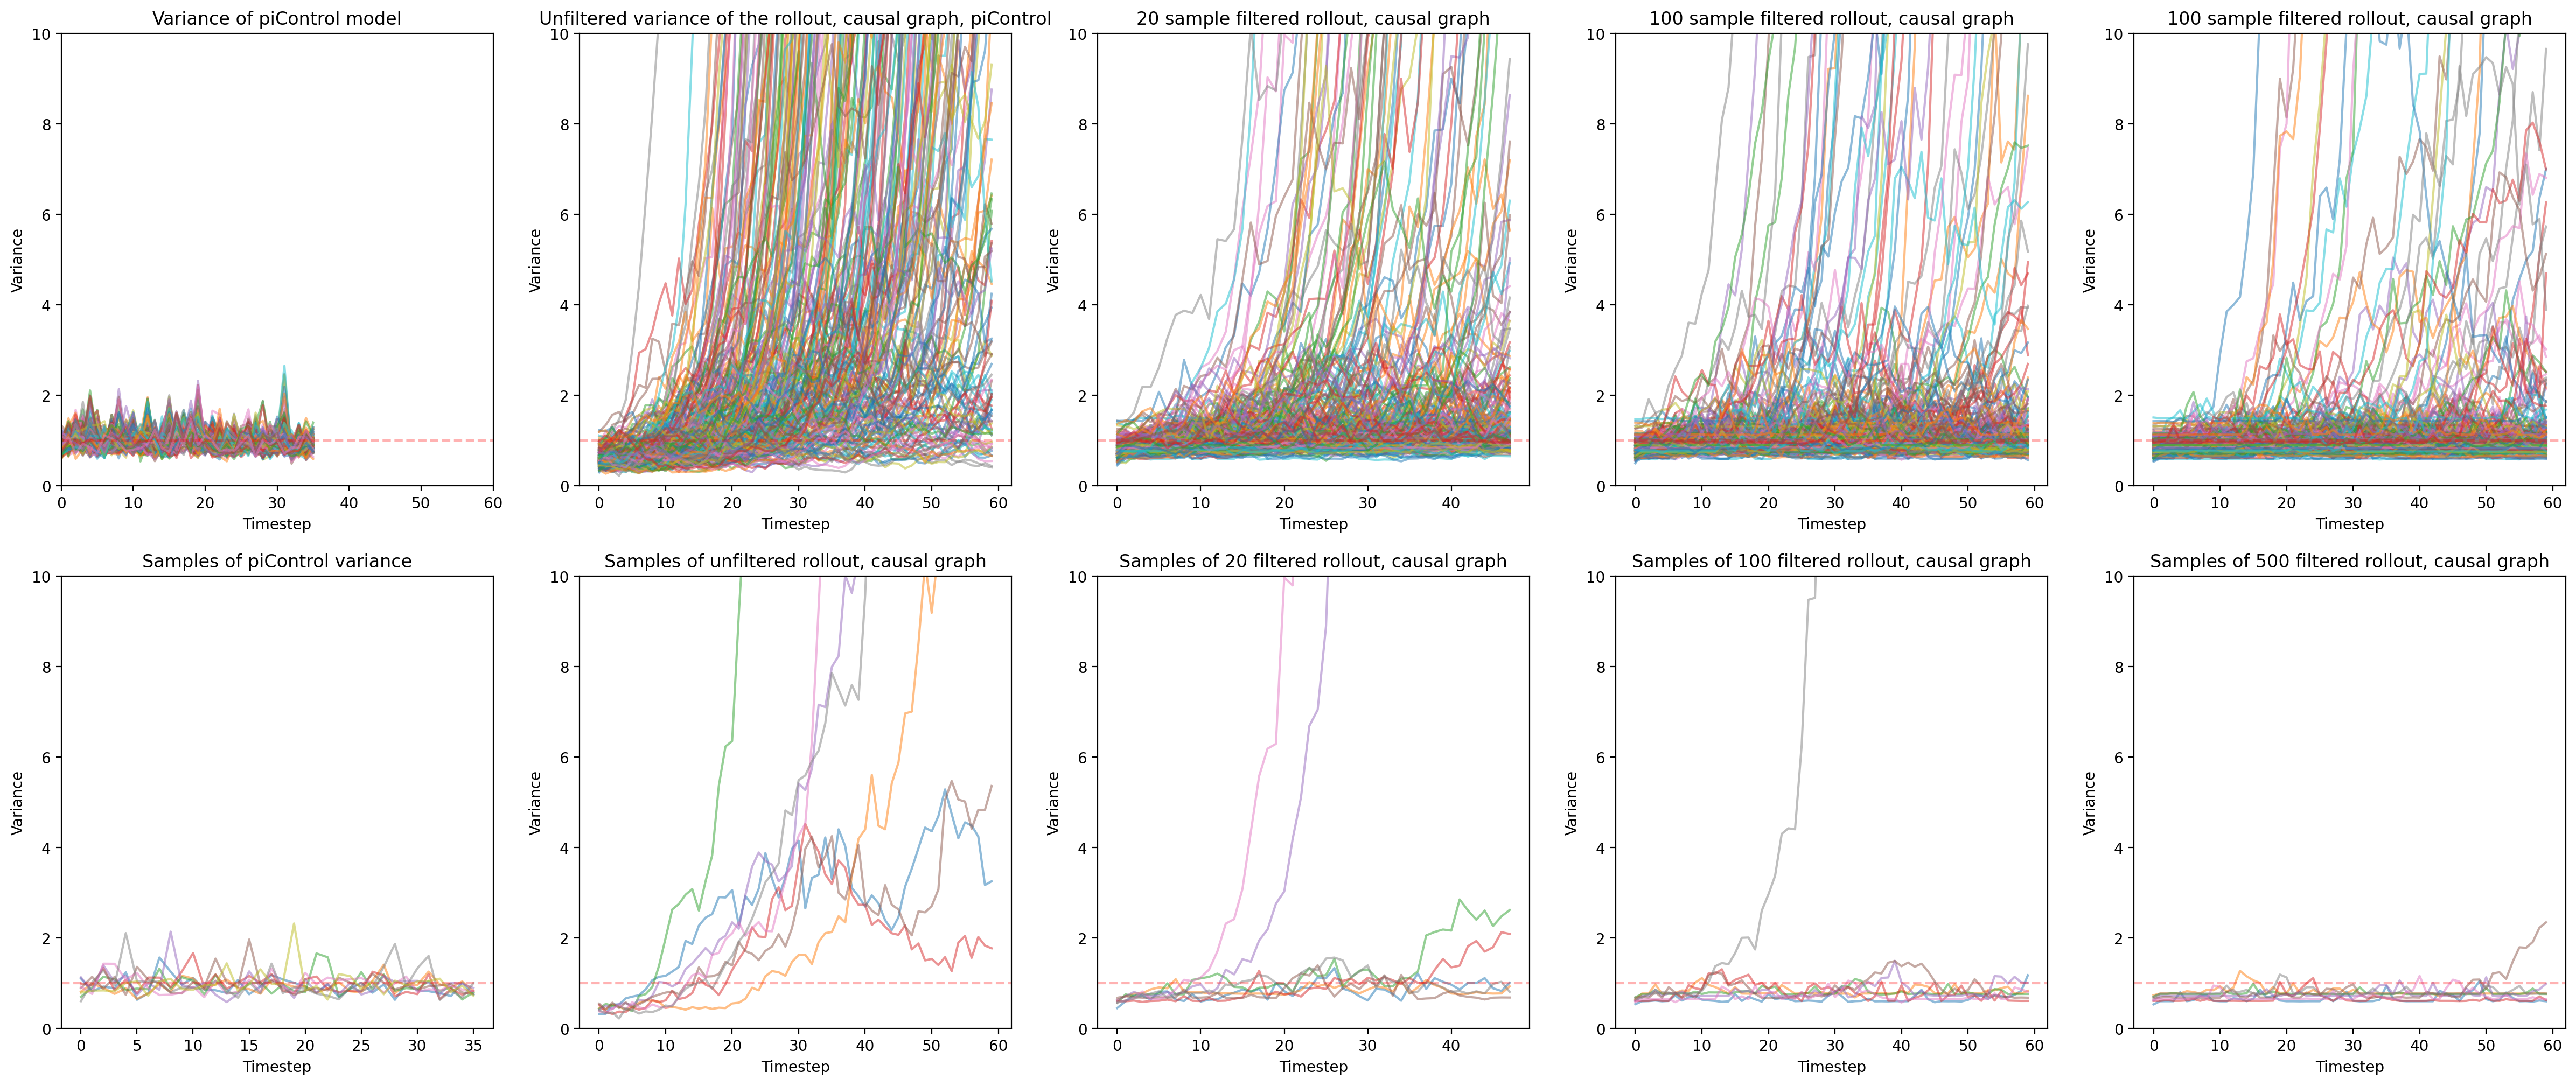

In [58]:
# make a figure with two subplots

fig, axs = plt.subplots(2, 5, figsize=(30, 12), dpi=200)

axs[0, 0].plot(np.var(cmip_dataset_ts_monthed.reshape(36, -1, 1, 6250)[:, :, 0, :], axis=(2)), alpha=0.5)
axs[0, 0].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[0, 0].set_ylim(0, 10)
axs[0, 0].set_xlim(0, 60)
axs[0, 0].set_ylabel('Variance')
axs[0, 0].set_xlabel('Timestep')
axs[0, 0].set_title('Variance of piControl model')

axs[0, 1].plot(np.var(each_timestep_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), alpha=0.5)
axs[0, 1].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[0, 1].set_ylim(0, 10)
axs[0, 1].set_ylabel('Variance')
axs[0, 1].set_xlabel('Timestep')
axs[0, 1].set_title('Unfiltered variance of the rollout, causal graph, piControl')

axs[0, 2].plot(np.var(each_timestep_pfvar_20_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), alpha=0.5)
axs[0, 2].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[0, 2].set_ylim(0, 10)
axs[0, 2].set_ylabel('Variance')
axs[0, 2].set_xlabel('Timestep')
axs[0, 2].set_title('20 sample filtered rollout, causal graph')

axs[0, 3].plot(np.var(each_timestep_pfvar_100_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), alpha=0.5)
axs[0, 3].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[0, 3].set_ylim(0, 10)
axs[0, 3].set_ylabel('Variance')
axs[0, 3].set_xlabel('Timestep')
axs[0, 3].set_title('100 sample filtered rollout, causal graph')

axs[0, 4].plot(np.var(each_timestep_pfvar_500_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), alpha=0.5)
axs[0, 4].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[0, 4].set_ylim(0, 10)
axs[0, 4].set_ylabel('Variance')
axs[0, 4].set_xlabel('Timestep')
axs[0, 4].set_title('100 sample filtered rollout, causal graph')

axs[1, 0].plot(np.var(cmip_dataset_ts_monthed.reshape(36, -1, 1, 6250)[:, [2, 24, 36, 48, 64, 88, 112, 132, 154], 0, :], axis=(2)), alpha=0.5)
axs[1, 0].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[1, 0].set_ylim(0, 10)
axs[1, 0].set_ylabel('Variance')
axs[1, 0].set_xlabel('Timestep')
axs[1, 0].set_title('Samples of piControl variance')

axs[1, 1].plot(np.var(each_timestep_finalvae_picontrol_array[:, 1, 100:108, 0, :], axis=(2)), alpha=0.5)
axs[1, 1].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[1, 1].set_ylim(0, 10)
axs[1, 1].set_ylabel('Variance')
axs[1, 1].set_xlabel('Timestep')
axs[1, 1].set_title('Samples of unfiltered rollout, causal graph')

axs[1, 2].plot(np.var(each_timestep_pfvar_20_samples_finalvae_picontrol_array[:, 1, 100:108, 0, :], axis=(2)), alpha=0.5)
axs[1, 2].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[1, 2].set_ylim(0, 10)
axs[1, 2].set_ylabel('Variance')
axs[1, 2].set_xlabel('Timestep')
axs[1, 2].set_title('Samples of 20 filtered rollout, causal graph')

axs[1, 3].plot(np.var(each_timestep_pfvar_100_samples_finalvae_picontrol_array[:, 1, 100:108, 0, :], axis=(2)), alpha=0.5)
axs[1, 3].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[1, 3].set_ylim(0, 10)
axs[1, 3].set_ylabel('Variance')
axs[1, 3].set_xlabel('Timestep')
axs[1, 3].set_title('Samples of 100 filtered rollout, causal graph')

axs[1, 4].plot(np.var(each_timestep_pfvar_500_samples_finalvae_picontrol_array[:, 1, 100:108, 0, :], axis=(2)), alpha=0.5)
axs[1, 4].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[1, 4].set_ylim(0, 10)
axs[1, 4].set_ylabel('Variance')
axs[1, 4].set_xlabel('Timestep')
axs[1, 4].set_title('Samples of 500 filtered rollout, causal graph')

Plot a video of the results here:

In [59]:
def plot_preds_icosa_robin_video_array(each_timestep, sample, coordinates:np.ndarray, out_dir:str, fname:str, show_plot:bool = True):
    '''
    Plotting global maps of the predictions using the Robinson projection.
    We use the plot_preds_icosa_robin function.
    '''
    img_array = []
    for timestep in range(len(each_timestep)):
        fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()}, figsize=(12, 6))
        plot_preds_icosa_robin(each_timestep[timestep, sample, 0, :], coordinates, ax, timestep, "plots", show_plot=show_plot)
        filename = f"{out_dir}/just_icosa_pred_timestep_{timestep}.png"
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width, height)
        img_array.append(img)
        # add a title to the plot
        ax.set_title(f'Autoregressive rollout, timestep {timestep}')
        # add a colorbar
        
    print('Done plotting all samples.')

    out = cv2.VideoWriter(f'{out_dir}/{fname}.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 3, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()


In [60]:
plot_preds_icosa_robin_video_array(each_timestep_finalvae_picontrol_array[:, 1, :, :, :], 32, coordinates, "plots", "finalvae_picontrol_32", show_plot=False)

plot_preds_icosa_robin_video_array(each_timestep_pfvar_20_samples_finalvae_picontrol_array[:, 1, :, :, :], 32, coordinates, "plots", "finalvae_filtered_20_picontrol_32", show_plot=False)

plot_preds_icosa_robin_video_array(each_timestep_pfvar_100_samples_finalvae_picontrol_array[:, 1, :, :, :], 32, coordinates, "plots", "finalvae_filtered_100_picontrol_32", show_plot=False)

plot_preds_icosa_robin_video_array(each_timestep_pfvar_500_samples_finalvae_picontrol_array[:, 1, :, :, :], 32, coordinates, "plots", "finalvae_filtered_500_picontrol_32", show_plot=False)

Done plotting all samples.


OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Done plotting all samples.


OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Done plotting all samples.


OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Done plotting all samples.


OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


# Evaluate the skill of the rollout here:

In [61]:
# Match up the forecast with the actual data

# here we have function to match up data from the autoregressive model to the CMIP data

def match_ar_indices_to_cmip_data(each_timestep_array: np.ndarray, cmip_dataset: np.ndarray, coordinates: np.ndarray) -> tuple[int, int]:
    """
    This function takes the autoregressive predictions and the CMIP dataset and finds the indices of the CMIP dataset
    that correspond to the autoregressive predictions. It returns a list of tuples, where the first element of the tuple
    is the index of the autoregressive prediction, and the second element is the index of the CMIP dataset.
    """
    list_of_indexes = []

    for x in range(0, each_timestep_array.shape[2]):
        for i in range(0, cmip_dataset.shape[0]):
            if np.sum(np.abs(each_timestep_array[0, 0, x, 0, :] - cmip_dataset[i, 0, :])) <= 10.0:
                list_of_indexes.append((x, i))
                print(f"Matched AR index {x} to CMIP index {i}")
    return list_of_indexes


In [62]:
cmip_dataset_ts_monthed.shape

(6012, 1, 6250)

In [63]:
list_of_indices = match_ar_indices_to_cmip_data(each_timestep_pfvar_20_samples_finalvae_picontrol_array, cmip_dataset_ts_monthed, coordinates)

# list_of_indices2 = match_ar_indices_to_cmip_data(each_timestep_finalvae_picontrol_array, cmip_dataset_ts_monthed, coordinates)
# assert list_of_indices == list_of_indices2


Matched AR index 0 to CMIP index 4
Matched AR index 1 to CMIP index 5
Matched AR index 2 to CMIP index 6
Matched AR index 3 to CMIP index 7
Matched AR index 4 to CMIP index 8
Matched AR index 5 to CMIP index 9
Matched AR index 6 to CMIP index 10
Matched AR index 7 to CMIP index 11
Matched AR index 8 to CMIP index 12
Matched AR index 9 to CMIP index 13
Matched AR index 10 to CMIP index 14
Matched AR index 11 to CMIP index 15
Matched AR index 12 to CMIP index 16
Matched AR index 13 to CMIP index 17
Matched AR index 14 to CMIP index 18
Matched AR index 15 to CMIP index 19
Matched AR index 16 to CMIP index 20
Matched AR index 17 to CMIP index 21
Matched AR index 18 to CMIP index 22
Matched AR index 19 to CMIP index 23
Matched AR index 20 to CMIP index 24
Matched AR index 21 to CMIP index 25
Matched AR index 22 to CMIP index 26
Matched AR index 23 to CMIP index 27
Matched AR index 24 to CMIP index 28
Matched AR index 25 to CMIP index 29
Matched AR index 26 to CMIP index 30
Matched AR index 

In [64]:
# Evaluate! the next step forecast skill...

each_timestep_pfvar_20_samples_finalvae_picontrol_array.shape

(48, 2, 256, 1, 6250)

In [65]:
array_of_indices = np.array(list_of_indices)
array_of_indices.shape

# select just the second column of this array

cmip_indices = array_of_indices[:, 1]

In [66]:
# now I can loop through each of these starting points and calculate the mean squared error for each of the samples

all_mses_finalvae_picontrol = []
all_maes_finalvae_picontrol = []

for sample in range(0, each_timestep_finalvae_picontrol_array.shape[2]):

    mse_per_sample = []
    mae_per_sample = []
    starting_point_per_sample = cmip_indices[sample]

    for timestep in range(0, 48):

        mse_per_sample.append(mean_squared_error(cmip_dataset_ts_monthed[starting_point_per_sample+timestep, 0, :], each_timestep_finalvae_picontrol_array[timestep, 1, sample, 0, :])) 
        mae_per_sample.append(mean_absolute_error(cmip_dataset_ts_monthed[starting_point_per_sample+timestep, 0, :], each_timestep_finalvae_picontrol_array[timestep, 1, sample, 0, :])) 

    all_mses_finalvae_picontrol.append(mse_per_sample)
    all_maes_finalvae_picontrol.append(mae_per_sample)

In [67]:
# now I can loop through each of these starting points and calculate the mean squared error for each of the samples

all_mses_pfvar_20_samples_finalvae_picontrol = []
all_maes_pfvar_20_samples_finalvae_picontrol = []

for sample in range(0, each_timestep_pfvar_20_samples_finalvae_picontrol_array.shape[2]):

    mse_per_sample = []
    mae_per_sample = []
    starting_point_per_sample = cmip_indices[sample]

    for timestep in range(0, 48):

        mse_per_sample.append(mean_squared_error(cmip_dataset_ts_monthed[starting_point_per_sample+timestep, 0, :], each_timestep_pfvar_20_samples_finalvae_picontrol_array[timestep, 1, sample, 0, :])) 
        mae_per_sample.append(mean_absolute_error(cmip_dataset_ts_monthed[starting_point_per_sample+timestep, 0, :], each_timestep_pfvar_20_samples_finalvae_picontrol_array[timestep, 1, sample, 0, :])) 

    all_mses_pfvar_20_samples_finalvae_picontrol.append(mse_per_sample)
    all_maes_pfvar_20_samples_finalvae_picontrol.append(mae_per_sample)

In [68]:
# now I can loop through each of these starting points and calculate the mean squared error for each of the samples

all_mses_pfvar_100_samples_picontrol = []
all_maes_pfvar_100_samples_picontrol = []

for sample in range(0, each_timestep_pfvar_100_samples_finalvae_picontrol_array.shape[2]):

    mse_per_sample = []
    mae_per_sample = []
    starting_point_per_sample = cmip_indices[sample]

    for timestep in range(0, 48):

        mse_per_sample.append(mean_squared_error(cmip_dataset_ts_monthed[starting_point_per_sample+timestep, 0, :], each_timestep_pfvar_100_samples_finalvae_picontrol_array[timestep, 1, sample, 0, :])) 
        mae_per_sample.append(mean_absolute_error(cmip_dataset_ts_monthed[starting_point_per_sample+timestep, 0, :], each_timestep_pfvar_100_samples_finalvae_picontrol_array[timestep, 1, sample, 0, :])) 

    all_mses_pfvar_100_samples_picontrol.append(mse_per_sample)
    all_maes_pfvar_100_samples_picontrol.append(mae_per_sample)

In [69]:
# now I can loop through each of these starting points and calculate the mean squared error for each of the samples

all_mses_pfvar_500_samples_picontrol = []
all_maes_pfvar_500_samples_picontrol = []

for sample in range(0, each_timestep_pfvar_500_samples_finalvae_picontrol_array.shape[2]):

    mse_per_sample = []
    mae_per_sample = []
    starting_point_per_sample = cmip_indices[sample]

    for timestep in range(0, 48):

        mse_per_sample.append(mean_squared_error(cmip_dataset_ts_monthed[starting_point_per_sample+timestep, 0, :], each_timestep_pfvar_500_samples_finalvae_picontrol_array[timestep, 1, sample, 0, :])) 
        mae_per_sample.append(mean_absolute_error(cmip_dataset_ts_monthed[starting_point_per_sample+timestep, 0, :], each_timestep_pfvar_500_samples_finalvae_picontrol_array[timestep, 1, sample, 0, :])) 

    all_mses_pfvar_500_samples_picontrol.append(mse_per_sample)
    all_maes_pfvar_500_samples_picontrol.append(mae_per_sample)

In [70]:
# now I can loop through each of these starting points and calculate the mean squared error for each of the samples

all_mses_t0_persistence = []
all_maes_t0_persistence = []

for sample in range(0, each_timestep_finalvae_picontrol_array.shape[2]):

    mse_per_sample = []
    mae_per_sample = []
    starting_point_per_sample = cmip_indices[sample]

    for timestep in range(0, 48):
        mse_per_sample.append(mean_squared_error(cmip_dataset_ts_monthed[starting_point_per_sample+timestep, 0, :], cmip_dataset_ts_monthed[starting_point_per_sample-1, 0, :])) 
        mae_per_sample.append(mean_absolute_error(cmip_dataset_ts_monthed[starting_point_per_sample+timestep, 0, :], cmip_dataset_ts_monthed[starting_point_per_sample-1, 0, :])) 

    all_mses_t0_persistence.append(mse_per_sample)
    all_maes_t0_persistence.append(mae_per_sample)

In [71]:
# make arrays out of this list

all_maes_finalvae_picontrol_array = np.array(all_maes_finalvae_picontrol)
all_maes_pfvar_20_samples_finalvae_picontrol_array = np.array(all_maes_pfvar_20_samples_finalvae_picontrol)
all_maes_pfvar_100_samples_finalvae_picontrol_array = np.array(all_maes_pfvar_100_samples_picontrol)
all_maes_pfvar_500_samples_finalvae_picontrol_array = np.array(all_maes_pfvar_500_samples_picontrol)

all_maes_t0_persistence_array = np.array(all_maes_t0_persistence)
#all_maes_t0_persistence_ssp_array = np.array(all_maes_t0_persistence_ssp)

In [75]:
# Assuming all_mses_array is defined elsewhere in your notebook

mean_finalvae_maes = np.mean(all_maes_finalvae_picontrol_array, axis=0)
median_finalvae_maes = np.median(all_maes_finalvae_picontrol_array, axis=0)
mean_finalvae_stds = np.std(all_maes_finalvae_picontrol_array, axis=0)

mean_pfvar_20_samples_finalvae_maes = np.mean(all_maes_pfvar_20_samples_finalvae_picontrol_array, axis=0)
median_pfvar_20_samples_finalvae_maes = np.median(all_maes_pfvar_20_samples_finalvae_picontrol_array, axis=0)
mean_pfvar_20_samples_finalvae_stds = np.std(all_maes_pfvar_20_samples_finalvae_picontrol_array, axis=0)

mean_pfvar_100_samples_finalvae_maes = np.mean(all_maes_pfvar_100_samples_finalvae_picontrol_array, axis=0)
median_pfvar_100_samples_finalvae_maes = np.median(all_maes_pfvar_100_samples_finalvae_picontrol_array, axis=0)
mean_pfvar_100_samples_finalvae_stds = np.std(all_maes_pfvar_100_samples_finalvae_picontrol_array, axis=0)

mean_pfvar_500_samples_finalvae_maes = np.mean(all_maes_pfvar_500_samples_finalvae_picontrol_array, axis=0)
median_pfvar_500_samples_finalvae_maes = np.median(all_maes_pfvar_500_samples_finalvae_picontrol_array, axis=0)
mean_pfvar_500_samples_finalvae_stds = np.std(all_maes_pfvar_500_samples_finalvae_picontrol_array, axis=0)

mean_persistence_maes = np.mean(all_maes_t0_persistence_array, axis=0)
median_persistence_maes = np.median(all_maes_t0_persistence_array, axis=0)
mean_persistence_stds = np.std(all_maes_t0_persistence_array, axis=0)

# Calculate the upper and lower bounds of the standard deviation
#upper_bound = mean_mses + mean_stds
#lower_bound = mean_mses - mean_stds

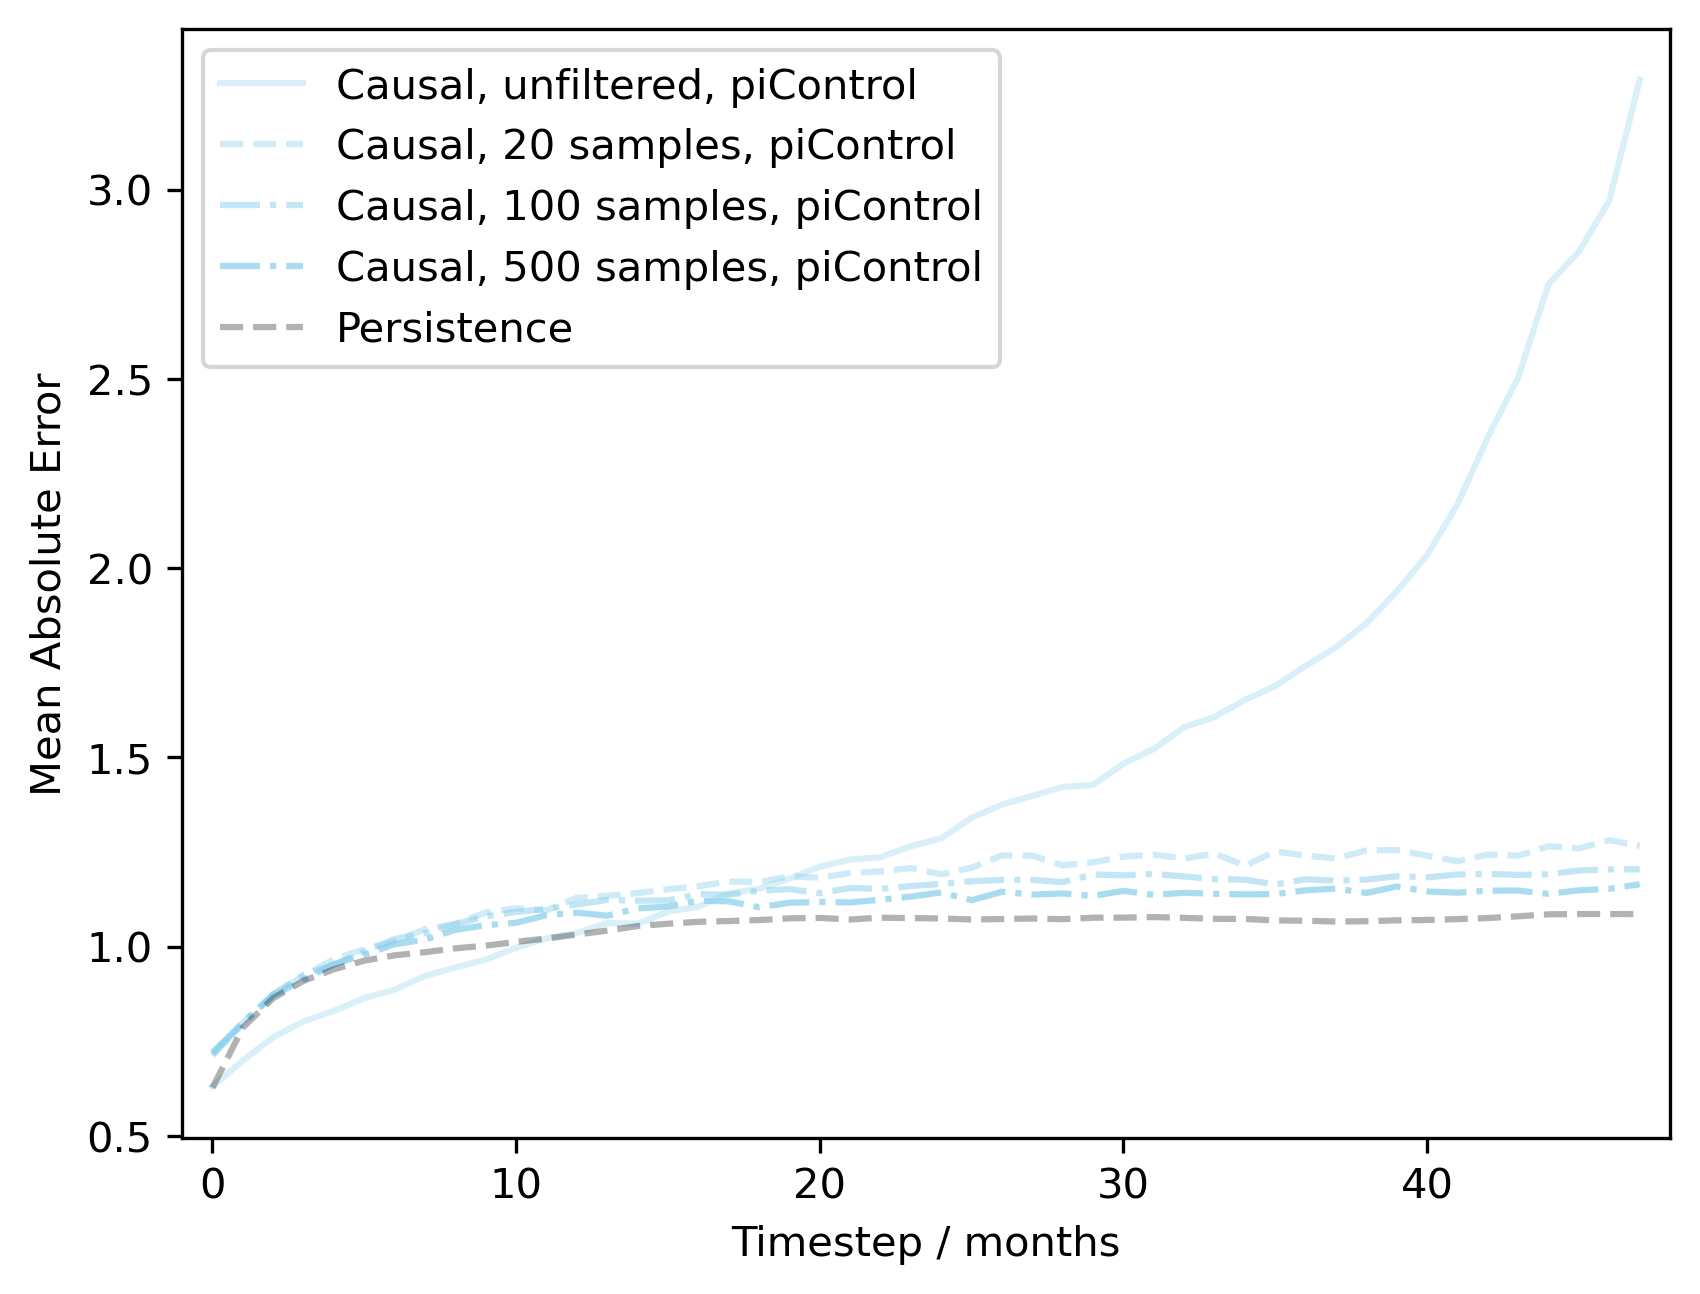

In [80]:
plt.figure(dpi=300)

# Plot the mean
#plt.plot(mean_finalvae_maes, label='Causal, unfiltered, piControl', color='purple', alpha=0.5)
#plt.plot(mean_pfvar_20_samples_finalvae_maes, label='Causal, 20 samples, piControl', color='purple', alpha=0.6, linestyle="--")
#plt.plot(mean_pfvar_100_samples_finalvae_maes, label='Causal, 100 samples, piControl', color='purple', alpha=0.7, linestyle="-.")
#plt.plot(mean_pfvar_500_samples_finalvae_maes, label='Causal, 500 samples, piControl', color='purple', alpha=0.8, linestyle="-.")

plt.plot(median_finalvae_maes, label='Causal, unfiltered, piControl', color='skyblue', alpha=0.3)
plt.plot(median_pfvar_20_samples_finalvae_maes, label='Causal, 20 samples, piControl', color='skyblue', alpha=0.4, linestyle="--")
plt.plot(median_pfvar_100_samples_finalvae_maes, label='Causal, 100 samples, piControl', color='skyblue', alpha=0.5, linestyle="-.")
plt.plot(median_pfvar_500_samples_finalvae_maes, label='Causal, 500 samples, piControl', color='skyblue', alpha=0.7, linestyle="-.")



#plt.plot(mean_vae_ssp245_mses, label='VAE SSP245')
plt.plot(mean_persistence_maes, label='Persistence', alpha=0.3, color='k', linestyle='--')


#plt.axhline(y=1.0, color='r', linestyle='--')
#plt.axvline(x=2, color='r', linestyle='--')

plt.ylabel('Mean Absolute Error')
plt.xlabel('Timestep / months')

# Plot the standard deviation bounds
#plt.fill_between(range(len(mean_mses)), lower_bound, upper_bound, color='gray', alpha=0.1, label='Standard Deviation')

#plt.ylim(0,5)
plt.xlim(-1,48)

# make y axis a log scale
#plt.yscale('log')

plt.legend()
plt.show()

# Leftovers.

In [133]:
# calculate the spatial spectra of the particle filtered rollout and the novae rollout


fft_true = torch.mean(torch.abs(torch.fft.rfft(y[:, :, :], dim=2)), dim=0)
# calculate the average spatial spectra of the individual predicted fields - I think this below is wrong
#print("y_pred pf shape:", each_timestep_pf_array.shape)
#print("y_pred novae shape:", each_timestep_novae_array.shape)

fft_pred = torch.mean(torch.abs(torch.fft.rfft(torch.Tensor(each_timestep_novae_array[:, 1, :, :, :]), dim=3)), dim=1)
fft_pred_pf = torch.mean(torch.abs(torch.fft.rfft(torch.Tensor(each_timestep_pf_array[:, 0, :, :, :]), dim=3)), dim=1)

# extend fft_true so it is the same value but extended to the same shape as fft_pred
fft_true = fft_true.repeat(120, 1, 1)

# assert that the first two elements of fft_true are the same
assert torch.allclose(fft_true[0, :, :], fft_true[1, :, :])

#print("fft_true shape after repeating:", fft_true.shape)
#print("fft_pred shape:", fft_pred.shape)

# calculate the difference between the true and predicted spatial spectra
spatial_spectra_score = torch.abs(fft_pred - fft_true)
spatial_spectra_score_pf = torch.abs(fft_pred_pf - fft_true)

print("Spatial spectra score raw from the fft:", spatial_spectra_score.shape)

# take the mean of the spatial spectra score across the variables and the wavenumbers, the final 2 axes
spatial_spectra_score = torch.mean(spatial_spectra_score, dim=(1, 2))
spatial_spectra_score_pf = torch.mean(spatial_spectra_score_pf, dim=(1, 2))


print('Lower is better')

#print("Spatial spectra score meaned:", spatial_spectra_score)
#print("Spatial spectra score meaned pf:", spatial_spectra_score_pf)

print("Raw - pf, if positive then pf is better:", spatial_spectra_score - spatial_spectra_score_pf)

Spatial spectra score raw from the fft: torch.Size([120, 3, 3126])
Lower is better
Raw - pf, if positive then pf is better: tensor([ 0.0176,  0.0277, -0.0065,  0.0765,  0.0826, -0.0056,  0.1119, -0.0526,
         0.0324,  0.0519,  0.0673,  0.0013,  0.2691,  0.1183,  0.2399,  0.2091,
         0.1685,  0.1151,  0.1653,  0.1339,  0.1754,  0.0705,  0.1000,  0.1840,
         0.3887,  0.2615,  0.4664,  0.2264,  0.2770,  0.3603,  0.3164,  0.3675,
         0.2581,  0.3469,  0.3362,  0.0799,  0.0084, -0.0495, -0.1462, -0.0595,
        -0.2358, -0.0607, -0.0031,  0.1123,  0.3391,  0.3665,  0.2256,  0.2194,
         0.1053, -0.0657, -0.0490,  0.2076,  0.2271,  0.1811,  0.2256,  0.0836,
        -0.0378, -0.2541, -0.3724, -0.2939, -0.4856, -0.4269, -0.3990, -0.3033,
        -0.3556, -0.5442, -0.7189, -0.6754, -0.4703, -0.3427,  0.0173,  0.1373,
         0.1904,  0.3600,  0.2990,  0.2137,  0.0080, -0.0773, -0.1895, -0.0554,
        -0.0755, -0.1673, -0.1977, -0.0248,  0.0654,  0.0403, -0.0099, -0.03